In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [3]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [4]:
import numpy as np
from albumentations import (
    Blur,
    CoarseDropout,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    Normalize,
    RandomResizedCrop,
    Resize,
    ShiftScaleRotate,
)
from albumentations.pytorch import ToTensorV2


def transform_image(image, is_train=True):
    image = image.numpy().astype(np.uint8)
    mean = [0.49031324, 0.45440296, 0.41580029]
    std = [0.22885894, 0.22473903, 0.2244801]

    if is_train:
        transforms = Compose(
            [
                HorizontalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(
                    hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5
                ),
                CoarseDropout(max_holes=3, max_height=32, max_width=32, p=0.25),
                Blur(blur_limit=3, p=0.25),
                GaussNoise(p=0.25),
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )
    else:
        transforms = Compose(
            [
                Normalize(mean=mean, std=std),
                ToTensorV2(),
            ]
        )

    transformed = transforms(image=image)
    return transformed["image"]


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = example["class"]
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image, id) if labeled=False
    for elem in maped_dataset:
        yield elem


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath


def load_tensor_batches(generator_dataset, batch_size=128, labeled=True, is_train=True):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        img = transform_image(image=elem[0], is_train=is_train).type(torch.float32)
        lbl = (
            torch.tensor(elem[1].numpy(), dtype=torch.float32)
            if labeled
            else elem[1].numpy().decode("utf-8")
        )
        batch_imgs.append(img)
        batch_lbls.append(lbl)
        i += 1
        if i % batch_size == 0:
            yield torch.stack(batch_imgs), torch.stack(batch_lbls)
            batch_imgs, batch_lbls = list(), list()

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [6]:
train_trf_dataset

<generator object load_dataset at 0x7d4e6e6544a0>

In [7]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

batch_train_tensors = next(load_tensor_batches(train_trf_dataset))

In [8]:
batch_train_tensors[0].shape

torch.Size([128, 3, 224, 224])

tensor(102.)


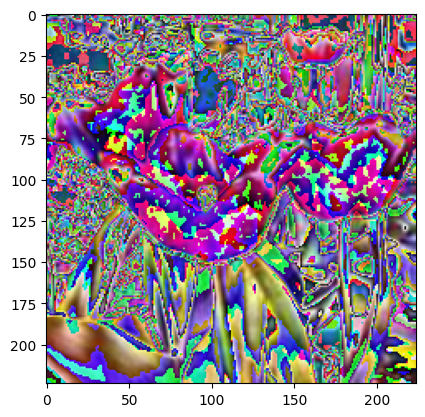

In [9]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [10]:
xm.get_xla_supported_devices()

E0000 00:00:1725030030.135171    5122 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']

In [11]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device

device(type='xla', index=0)

In [17]:
import math

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


class xlm_fully_conv(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.3),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.3),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.3),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(p=0.3),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 104),
        )

    def forward(self, batch):
        return F.log_softmax(self.model(batch), dim=1)

In [18]:
xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
output = xlm_model(batch_train_tensors[0].to(device, dtype=torch.float32))

In [19]:
print(sorted(np.unique(torch.argmax(output, dim=1).detach().cpu().numpy())))

[0, 2, 12, 14, 16, 19, 20, 23, 25, 26, 27, 29, 33, 35, 36, 38, 40, 43, 45, 47, 48, 49, 58, 62, 66, 68, 69, 71, 74, 76, 79, 86, 90, 91, 94, 95, 99, 100]


In [20]:
import torch_xla.distributed.parallel_loader as pl
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)

num_epochs = 100
loss = nn.NLLLoss()
opt = torch.optim.Adam(xlm_model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3, verbose=True)
batch_size = 512
rate_tracker_train = xm.RateTracker()
rate_tracker_val = xm.RateTracker()

train_losses = []
val_losses = []

plt.ion()

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    xlm_model.train()
    batch_generator_train = load_tensor_batches(
        load_dataset(get_recursive_paths(path, "train")), batch_size, is_train=True
    )
    train_loader = pl.ParallelLoader(batch_generator_train, [device])
    epoch_train_loss = 0

    for iteration, train_batch in enumerate(train_loader.per_device_loader(xm.xla_device())):
        opt.zero_grad()
        train_imgs, train_lbls = train_batch[0].to(device, dtype=torch.float32), train_batch[1].to(
            device, dtype=torch.float32
        )

        lbls_predict = xlm_model(train_imgs)
        output = loss(lbls_predict, train_lbls)
        output.backward()
        xm.optimizer_step(opt)

        epoch_train_loss += output.item()

        if iteration % 10 == 0:
            f1 = metrics.f1_score(
                train_lbls.detach().cpu().numpy(),
                torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                average="macro",
            )
            print(f"Loss: {output.detach().cpu()}")
            print(f"F1-score: {f1}")
            print(f"Rate: {rate_tracker_train.rate()} examples/sec")

        rate_tracker_train.add(batch_size)
        xm.mark_step()

    train_losses.append(epoch_train_loss / iteration)

    xlm_model.eval()
    batch_generator_val = load_tensor_batches(
        load_dataset(get_recursive_paths(path, "val")), batch_size, is_train=False
    )
    val_loader = pl.ParallelLoader(batch_generator_val, [device])
    losses, f1scores = list(), list()
    epoch_val_loss = 0

    for iteration, val_batch in enumerate(val_loader.per_device_loader(xm.xla_device())):
        val_imgs, val_lbls = val_batch[0].to(device, dtype=torch.float32), val_batch[1].to(
            device, dtype=torch.float32
        )

        with torch.no_grad():
            lbls_predict = xlm_model(val_imgs)
            output = loss(lbls_predict, val_lbls)
            score = metrics.f1_score(
                val_lbls.detach().cpu().numpy(),
                torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                average="macro",
            )

        losses.append(output.detach().cpu())
        f1scores.append(score)
        rate_tracker_val.add(batch_size)

        epoch_val_loss += output.item()

        xm.mark_step()

    val_losses.append(epoch_val_loss / iteration)

    scheduler.step(np.mean(np.array(losses)))

    print(f"Validation")
    print(f"Loss: {np.mean(np.array(losses))}")
    print(f"F1-score: {np.mean(np.array(f1scores))}")
    print(f"Rate: {rate_tracker_val.rate()} examples/sec")

/usr/local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 0
Loss: 4.7088165283203125
F1-score: 0.00976190476190476
Rate: 0.0 examples/sec
Loss: 3.8596091270446777
F1-score: 0.014652137314427664
Rate: 96.37631055389895 examples/sec
Loss: 3.6036977767944336
F1-score: 0.02867805507493514
Rate: 199.02657976007382 examples/sec
Validation
Loss: 4.1691670417785645
F1-score: 0.018427589641588256
Rate: 34.3809122948771 examples/sec
Epoch: 1
Loss: 3.598928451538086
F1-score: 0.027626094023578757
Rate: 139.27107590890796 examples/sec
Loss: 3.3963546752929688
F1-score: 0.030437317229792708
Rate: 190.59814661258798 examples/sec
Loss: 3.355011224746704
F1-score: 0.025722445981920795
Rate: 169.68857750963002 examples/sec
Validation
Loss: 3.345183849334717
F1-score: 0.03155856285010309
Rate: 42.02377517355376 examples/sec
Epoch: 2
Loss: 3.2789273262023926
F1-score: 0.03184693994709192
Rate: 126.47227084334865 examples/sec
Loss: 3.2844817638397217
F1-score: 0.03648717191760449
Rate: 185.35103320865556 examples/sec
Loss: 3.1845295429229736
F1-score: 0.0

KeyboardInterrupt: 

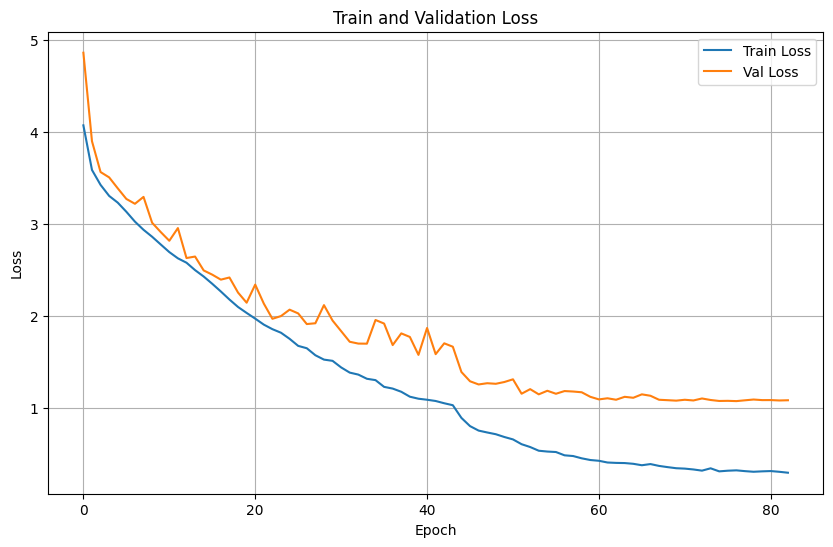

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [22]:
from collections import defaultdict


xlm_model.eval()
test_data = next(
    load_tensor_batches(
        load_dataset(get_recursive_paths(path, "test"), labeled=False),
        batch_size=1,
        labeled=False,
        is_train=False,
    )
)

test_imgs, test_filename = test_data[0].to(device, dtype=torch.float32), test_data[1]
lbls_predict = xlm_model(test_imgs)

print(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()), test_filename)

TypeError: expected Tensor as element 0 in argument 0, but got str

In [ ]:
from collections import defaultdict

import pandas as pd


xlm_model.eval()
test_data = load_tensor_batches(
    load_dataset(get_recursive_paths(path, "test"), labeled=False), batch_size=1, labeled=False
)
test_dataframe = defaultdict(list)

for i, test_batch in enumerate(test_data):
    test_imgs, test_filename = test_batch[0].to(device, dtype=torch.float32), test_batch[1]
    lbls_predict = xlm_model(test_imgs)
    test_dataframe["id"].append(*test_filename)
    test_dataframe["label"].append(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()))

In [ ]:
solution = pd.DataFrame(test_dataframe).reset_index(drop=True)

In [ ]:
solution.head(5)

In [ ]:
solution.to_csv(f"conv_baseline_solution.csv", index=False)